# House Price Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

### Pipelines

In [2]:
# This FeatureEngineer class Recommend by ChatGPT
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Feature engineering: Add new columns
        X = X.copy()
        X['HouseAge'] = X['YrSold'] - X['YearBuilt']
        X['RemodelAge'] = X['YrSold'] - X['YearRemodAdd']
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['TotalBath'] = X['FullBath'] + 0.5 * X['HalfBath'] + X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']
        X['HasPorch'] = np.where(X['OpenPorchSF'] > 0, 1, 0)

        # Polynomial and interaction features
        X['OverallQual_GrLivArea'] = X['OverallQual'] * X['GrLivArea']
        X['GarageCars_GarageArea'] = X['GarageCars'] * X['GarageArea']

        # Bin continuous variables
        X['GrLivArea_binned'] = pd.cut(X['GrLivArea'], bins=[0, 1000, 2000, 4000, np.inf], labels=['Small', 'Medium', 'Large', 'Very Large'])

        # Cluster Neighborhood based on SalePrice
        neighborhood_avg_price = df.groupby('Neighborhood')['SalePrice'].mean()
        kmeans = KMeans(n_clusters=3,n_init=10).fit(neighborhood_avg_price.values.reshape(-1, 1))
        X['NeighborhoodCluster'] = kmeans.predict(X['Neighborhood'].map(neighborhood_avg_price).values.reshape(-1, 1))

        # Drop less useful columns
        X = X.drop(columns=['YearBuilt', 'YearRemodAdd', 'YrSold', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath'])

        return X

class RemoveColumn(BaseEstimator, TransformerMixin):

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns)
    
class EncodeAndImpute(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        x_cat = X.select_dtypes(['category','object'])
        x_num = X.select_dtypes(['int64','float64'])
        """The missing values are filled with zero because the values are missed not randomly in most
    it missed because the value is not available like the house dont have any basement or garage
    don't have value related to it that's why that values are missing same goes for categorical data"""
        x_num = x_num.fillna(0)
        x_cat = x_cat.apply(LabelEncoder().fit_transform)
        X = pd.concat([x_num,x_cat],axis=1)
        return X

## Feature Selection

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

In [6]:
train_df = pd.read_csv('train.csv')
# removing missing value columns based on percentage of missing
missing_percent = train_df.isnull().mean() * 100 
train_df = train_df.drop(columns=missing_percent[missing_percent > 20].index)
train_df = train_df.drop(columns=['Id'],axis=1)

In [7]:
numerical_data = train_df.select_dtypes(['float64','int64'])
categorical_data = train_df.select_dtypes(['category','object'])
numeral_clos = numerical_data.columns.to_list()

In [8]:
X = numerical_data.drop(columns=['SalePrice'])
y = np.log1p(train_df['SalePrice']) # normalize the target variable

X = X.fillna(0) 

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [11]:
X_cat = categorical_data.fillna('None')
X_cat = X_cat.apply(LabelEncoder().fit_transform)

model = RandomForestRegressor()
model.fit(X_cat,y)
# finding the feature importance using random forest
importance = model.feature_importances_

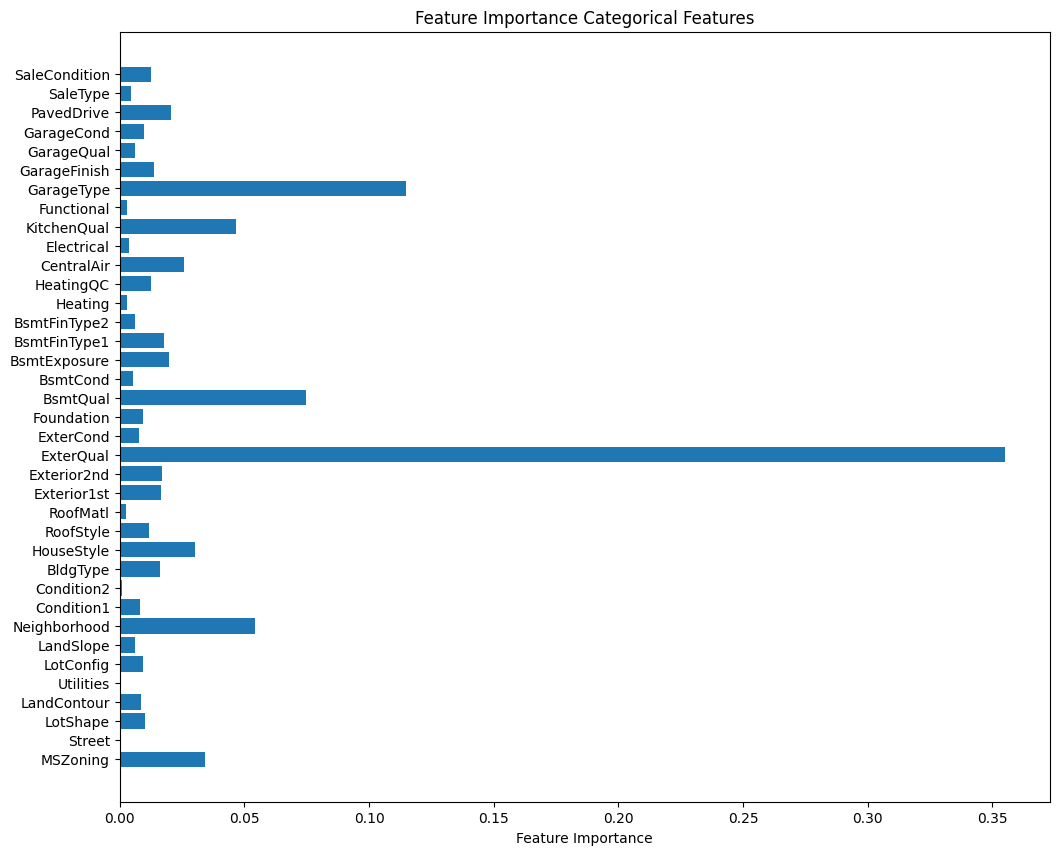

In [10]:
plt.figure(figsize=(12, 10))
plt.title("Feature Importance Categorical Features")
plt.barh(range(len(importance)), importance)
plt.yticks(range(len(importance)), X_cat.columns.to_list())
plt.xlabel("Feature Importance")
plt.show()

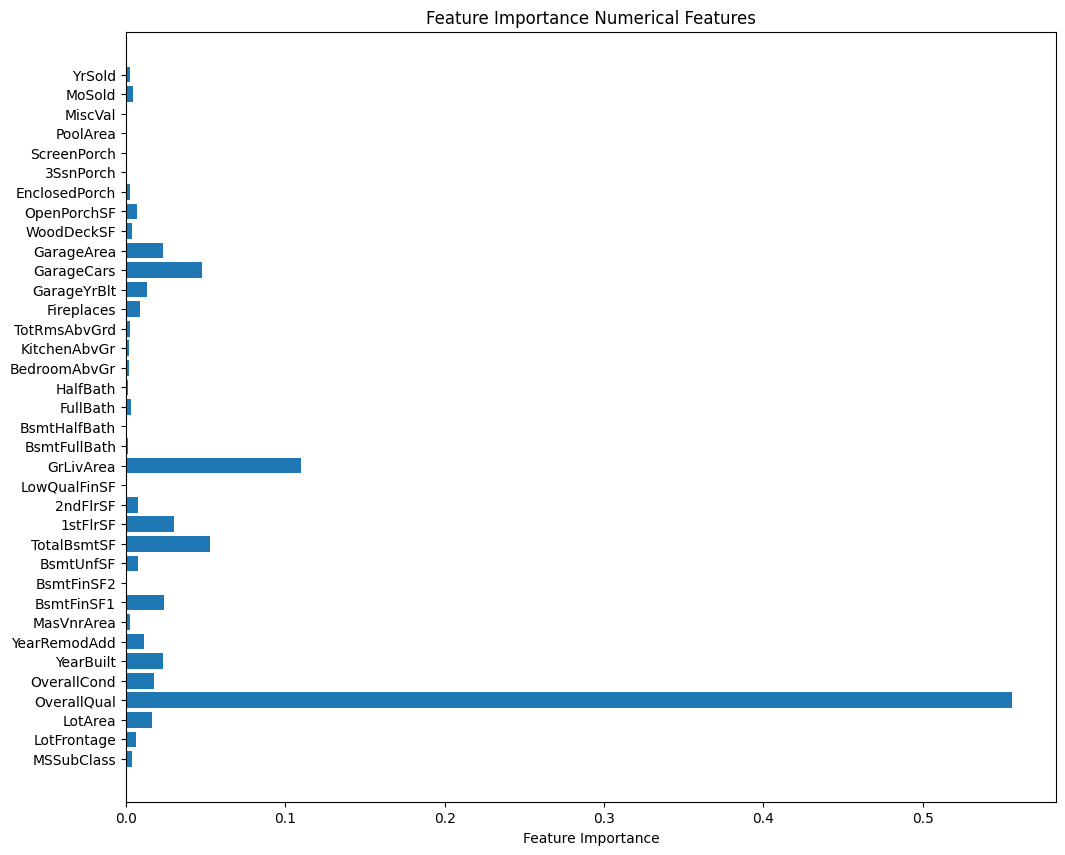

In [11]:
model = RandomForestRegressor()
model.fit(X,y)
importance_numerical = model.feature_importances_
plt.figure(figsize=(12, 10))
plt.title("Feature Importance Numerical Features")
plt.barh(range(len(importance_numerical)), importance_numerical)
plt.yticks(range(len(importance_numerical)), X.columns.to_list())
plt.xlabel("Feature Importance")
plt.show()

In [12]:
Top_k_numerical_features =SelectKBest(score_func=f_regression, k=14).fit(X,y)
Top_k_numerical_features.get_feature_names_out()

array(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea'], dtype=object)

In [13]:
Top_k_numerical_features =SelectKBest(score_func=mutual_info_regression, k=14).fit(X,y)
Top_k_numerical_features.get_feature_names_out()

array(['MSSubClass', 'LotFrontage', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea'], dtype=object)

In [14]:
from sklearn.feature_selection import VarianceThreshold
# maybe useless here
selector = VarianceThreshold(threshold=0.8)
selector.feature_names_in_ = X.columns.to_list()
selector.fit(X,y)
selector.get_feature_names_out()

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd',
       'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'], dtype=object)

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

model = LinearRegression()
selector = RFECV(model, step=1, cv=10, scoring='neg_mean_squared_error')
selector.feature_names_in_ = X.columns.to_list()
selector.fit(X,y)
selector.get_feature_names_out()

array(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'ScreenPorch', 'PoolArea', 'YrSold'], dtype=object)

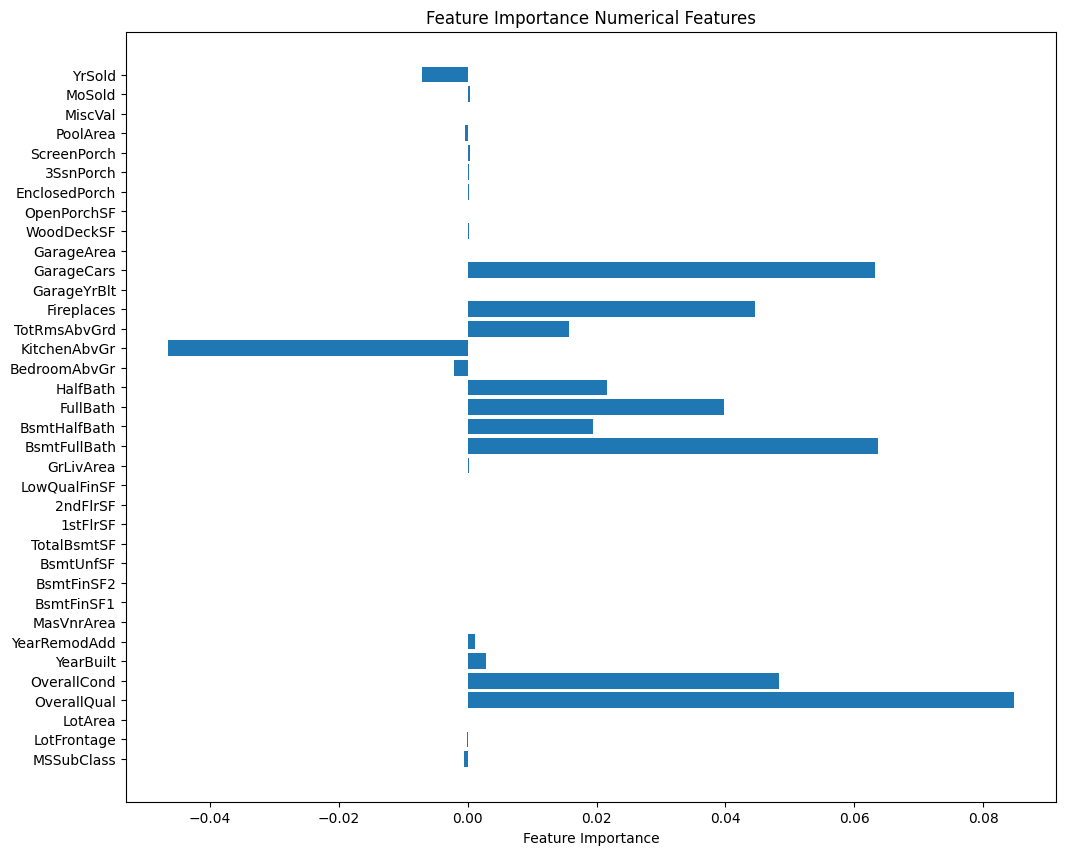

In [16]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X, y)
plt.figure(figsize=(12, 10))
plt.title("Feature Importance Numerical Features")
plt.barh(range(len(model.coef_)), model.coef_)
plt.yticks(range(len(model.coef_)), X.columns.to_list())
plt.xlabel("Feature Importance")
plt.show()


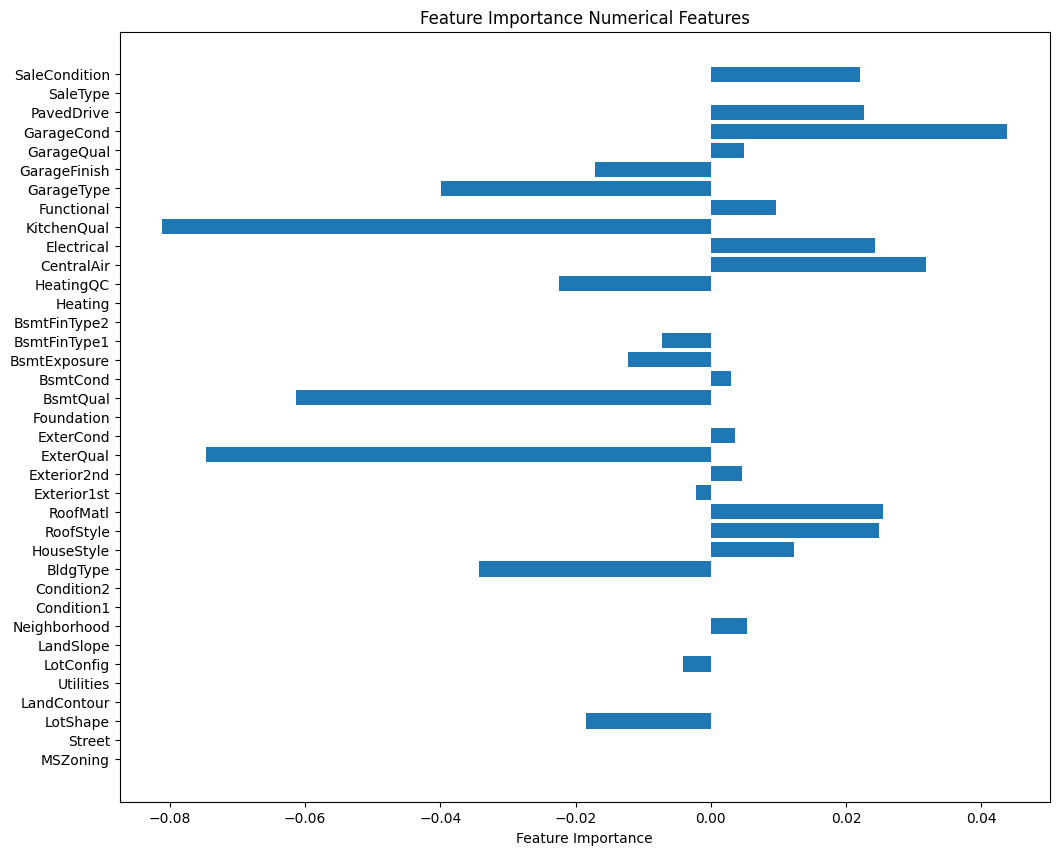

In [17]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.01)
model.fit(X_cat, y)
plt.figure(figsize=(12, 10))
plt.title("Feature Importance Numerical Features")
plt.barh(range(len(model.coef_)), model.coef_)
plt.yticks(range(len(model.coef_)), X_cat.columns.to_list())
plt.xlabel("Feature Importance")
plt.show()


## EDA

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
pd.concat([X,X_cat],axis=1).corrwith(y).abs().sort_values(ascending=False)

OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
                  ...   
MiscVal         0.020021
Utilities       0.012632
BsmtHalfBath    0.005149
BsmtFinSF2      0.004832
Condition2      0.001327
Length: 73, dtype: float64

<Axes: title={'center': 'SalePrice Before Log Transformation'}, xlabel='SalePrice', ylabel='Count'>

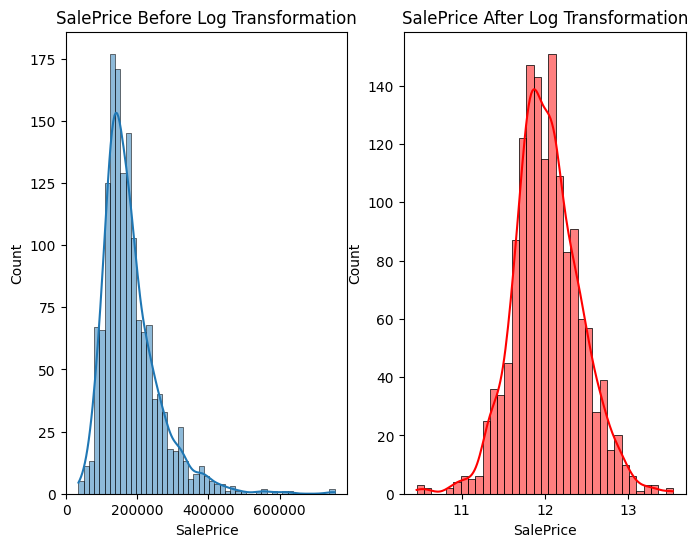

In [13]:
fig,axes = plt.subplots(1,2,figsize=(8,6))
sns.histplot(data=y, kde=True,ax=axes[1],color="red")
axes[0].set_title("SalePrice Before Log Transformation")
axes[1].set_title("SalePrice After Log Transformation")
sns.histplot(data=numerical_data["SalePrice"], kde=True,ax=axes[0])


<Axes: >

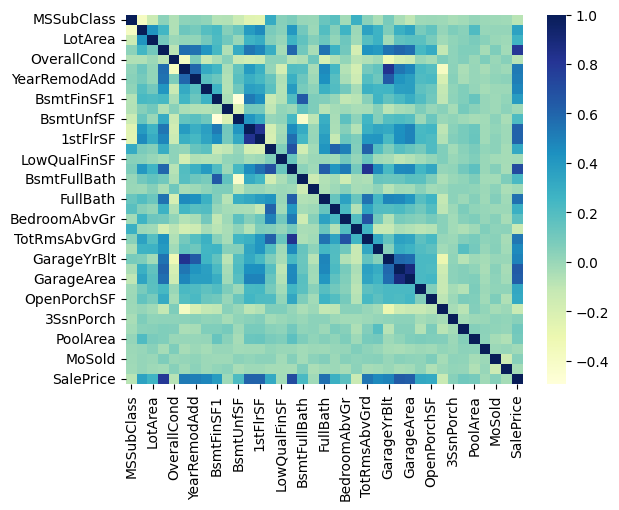

In [21]:
sns.heatmap(numerical_data.corr(),cmap="YlGnBu")

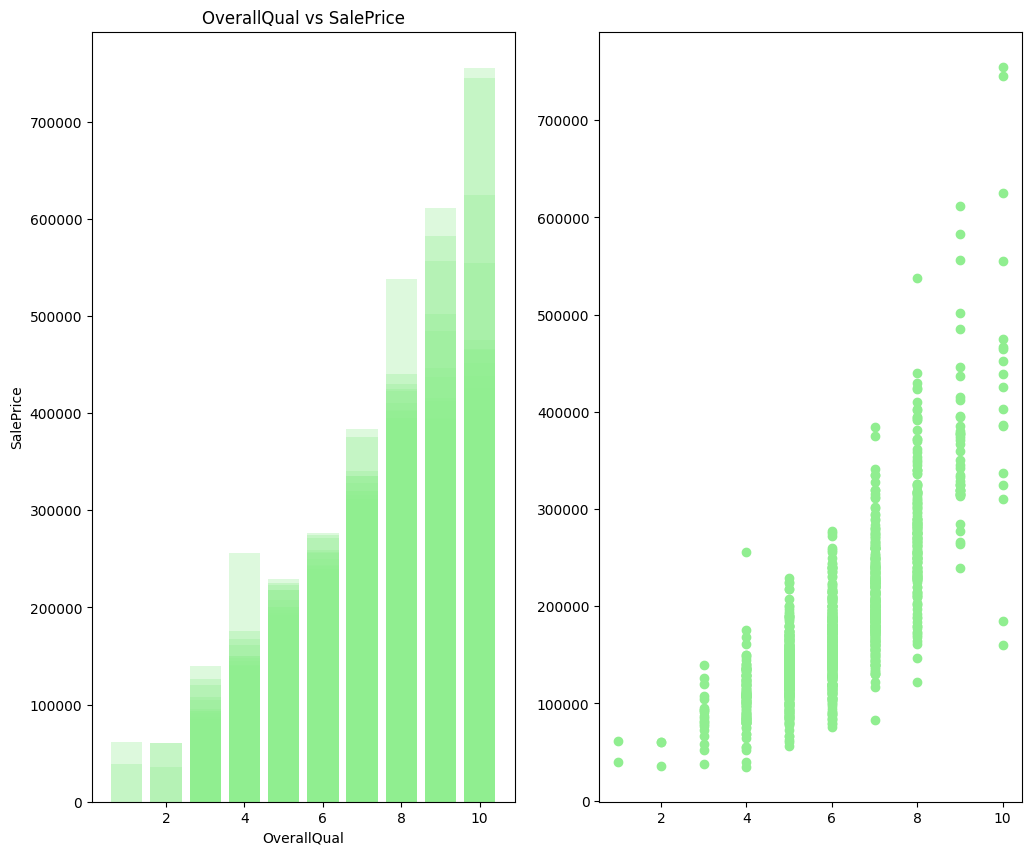

In [22]:
plt.figure(figsize=(12, 10))

plt.subplot(1,2,1)
plt.title("OverallQual vs SalePrice")
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")
plt.bar(X['OverallQual'],numerical_data['SalePrice'],color="lightgreen",alpha=0.3)
plt.subplot(1,2,2)
plt.scatter(X['OverallQual'],numerical_data['SalePrice'],color="lightgreen")

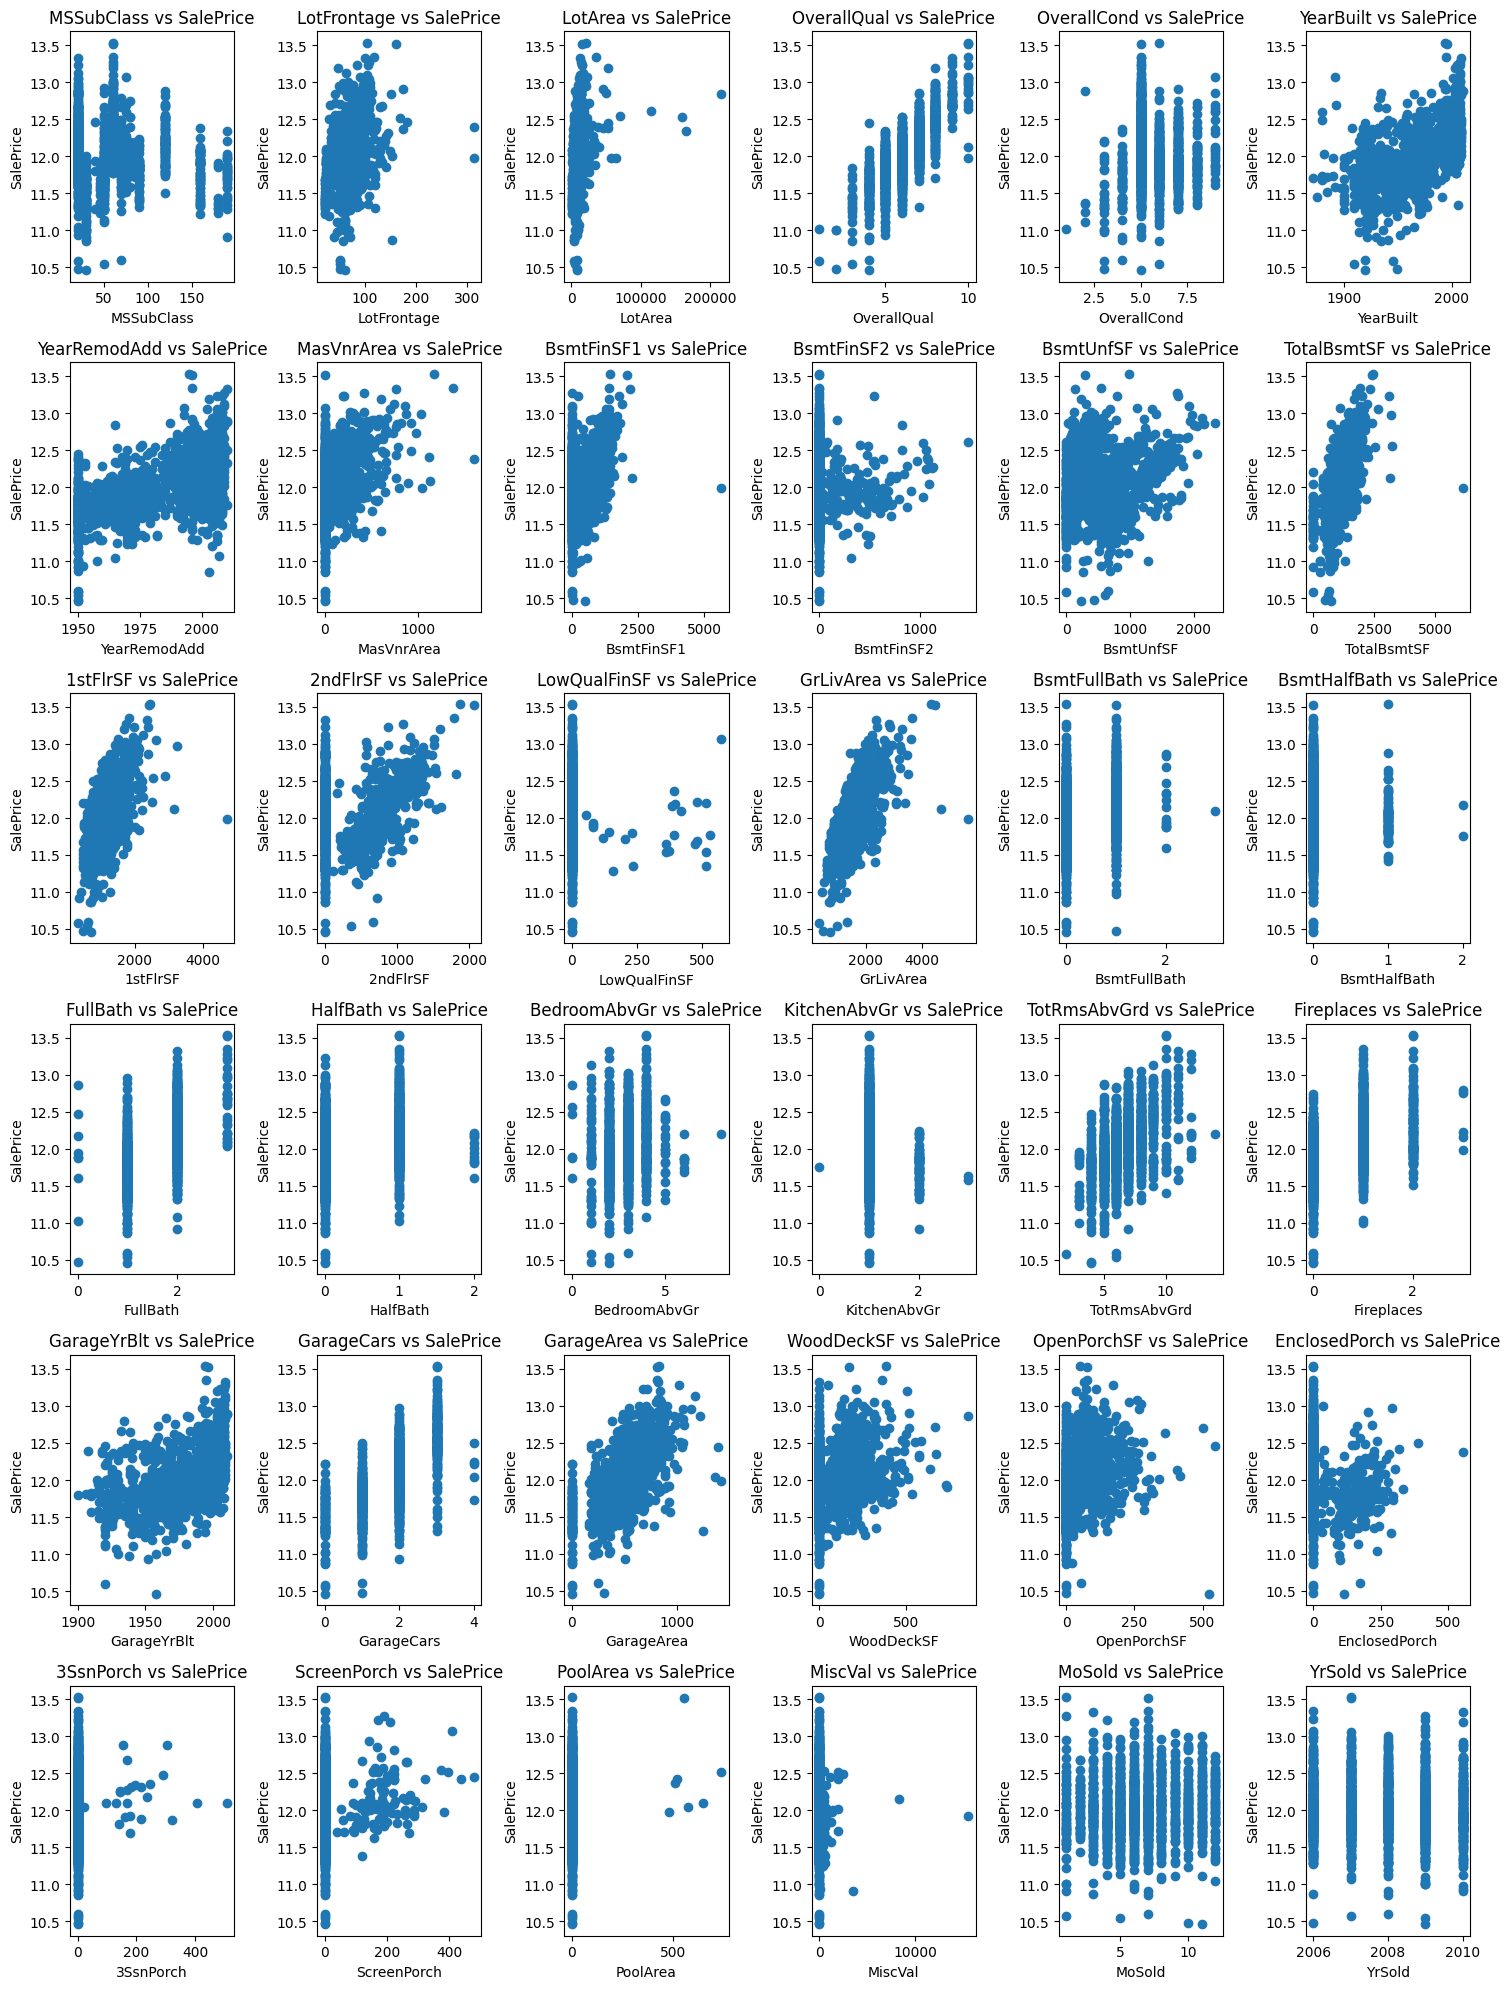

In [23]:
fig,axes = plt.subplots(nrows=6,ncols=6,figsize=(15,20))
for i,ax in enumerate(axes.flat):
    ax.scatter(numerical_data[numeral_clos[i]],y)
    ax.set_title(f"{numeral_clos[i]} vs SalePrice")
    ax.set_ylabel( "SalePrice")
    ax.set_xlabel(numeral_clos[i])
fig.tight_layout()
plt.show()

In [14]:
df = pd.read_csv('train.csv')

In [15]:
FeatureEngineer_data = FeatureEngineer().fit_transform(df)
FeatureEngineer_data = FeatureEngineer_data.drop(columns=['Id'],axis=1)
FeatureEngineer_data = FeatureEngineer_data.drop(columns=['MasVnrType','FireplaceQu'])

In [16]:
# Separating categorical and numerical features
featureEngineered_cat_data = FeatureEngineer_data.select_dtypes(['category', 'object'])
featureEngineered_numerical_data = FeatureEngineer_data.select_dtypes(['float64', 'int64'])

# Handling missing values in numerical and categorical data
X_featureEngineered_numerical = featureEngineered_numerical_data.drop(columns=['SalePrice'])  # Dropping the target column
X_featureEngineered_numerical = X_featureEngineered_numerical.fillna(0)  # Filling missing values with 0
X_cat_featureEngineered = featureEngineered_cat_data.apply(LabelEncoder().fit_transform)


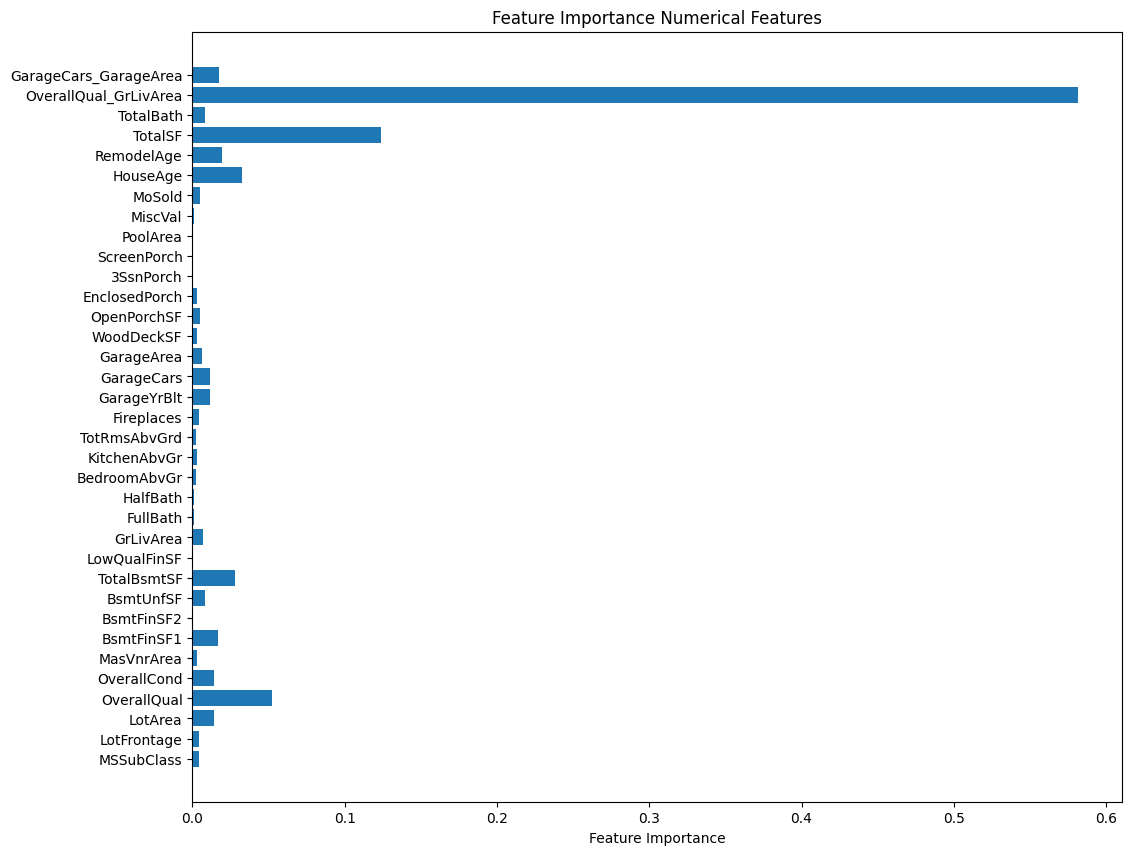

In [17]:

model = RandomForestRegressor()
model.fit(X_featureEngineered_numerical,y)

importance = model.feature_importances_

plt.figure(figsize=(12, 10))
plt.title("Feature Importance Numerical Features")
plt.barh(range(len(importance)), importance)
plt.yticks(range(len(importance)), X_featureEngineered_numerical.columns.to_list())
plt.xlabel("Feature Importance")
plt.show()

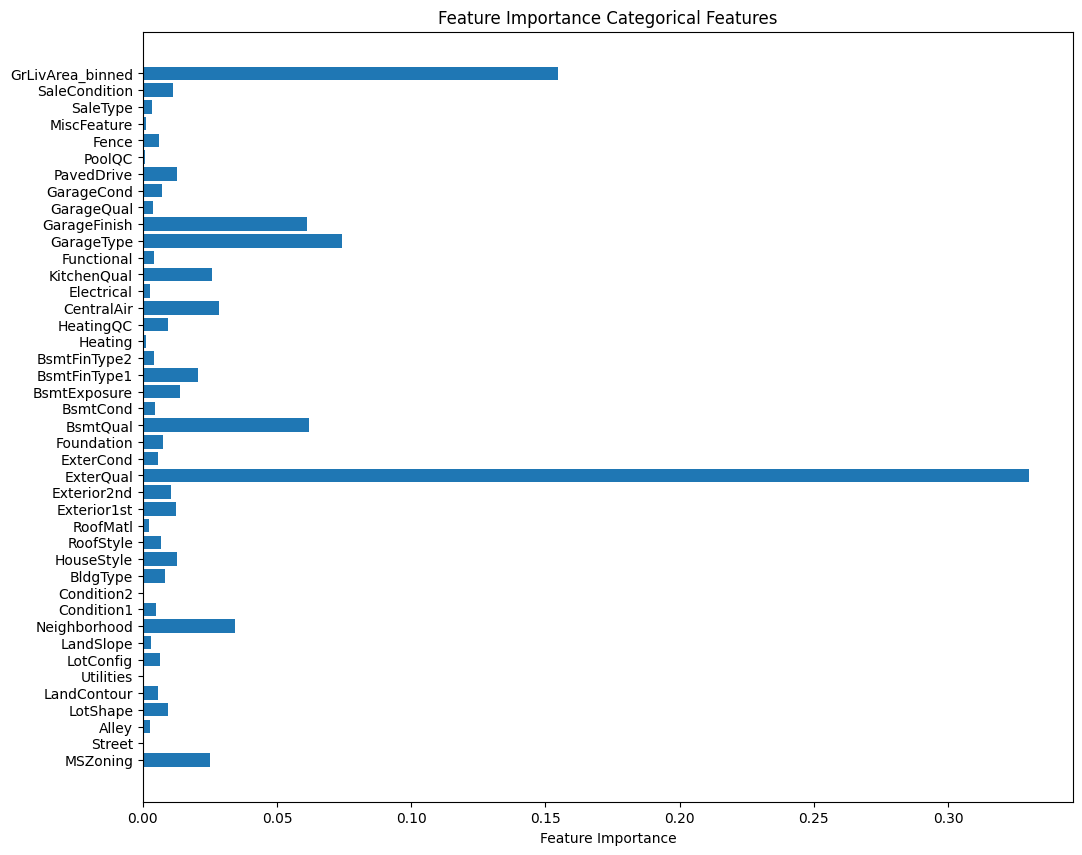

In [18]:

model = RandomForestRegressor()
model.fit(X_cat_featureEngineered,y)

importance = model.feature_importances_

plt.figure(figsize=(12, 10))
plt.title("Feature Importance Categorical Features")
plt.barh(range(len(importance)), importance)
plt.yticks(range(len(importance)), X_cat_featureEngineered.columns.to_list())
plt.xlabel("Feature Importance")
plt.show()

Selected Features: ['OverallQual', 'KitchenAbvGr', 'GarageCars', 'TotalSF', 'TotalBath', 'OverallQual_GrLivArea', 'GarageCars_GarageArea', 'MSZoning', 'ExterQual', 'CentralAir', 'KitchenQual', 'GarageFinish']
Total selected Features: 12


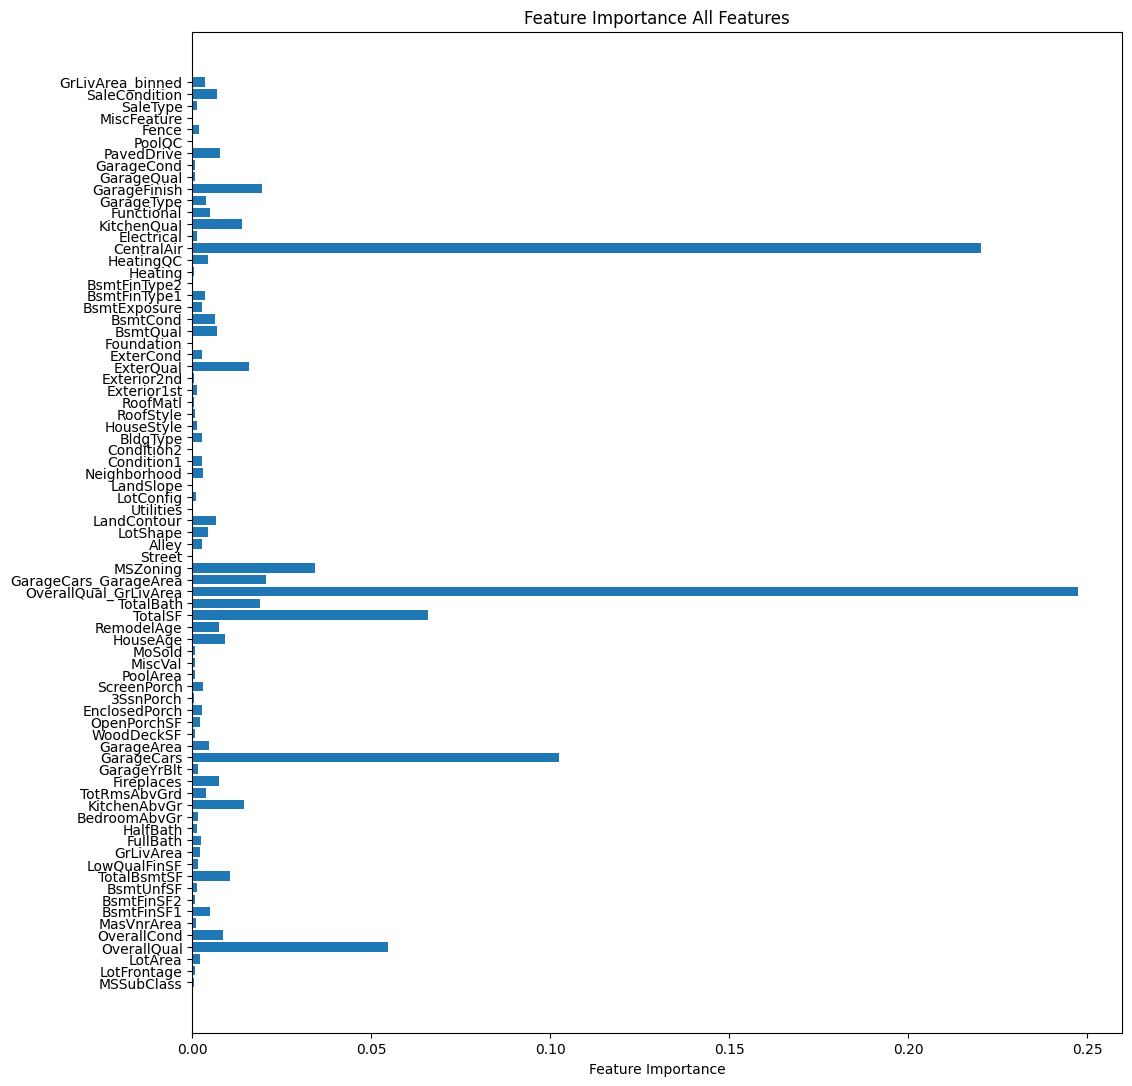

In [19]:
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
x_data = pd.concat([X_featureEngineered_numerical,X_cat_featureEngineered],axis=1)
y_data = y

model = XGBRegressor()
model.fit(x_data,y_data)

importance = model.feature_importances_
selector = SelectFromModel(model, prefit=True)
selected_features = x_data.columns[selector.get_support()].to_list()

print("Selected Features:", selected_features)
print("Total selected Features:", len(selected_features))
plt.figure(figsize=(12, 13))
plt.title("Feature Importance All Features")
plt.barh(range(len(importance)), importance)
plt.yticks(range(len(importance)), x_data.columns.to_list())
plt.xlabel("Feature Importance")
plt.show()

In [42]:
indices = np.argsort(importance)[::-1]

# Print feature ranking
for i in range(20):
    print(f"{i + 1}. Feature {x_data.columns[indices[i]]} ({importance[indices[i]]})")

1. Feature OverallQual_GrLivArea (0.24747462570667267)
2. Feature CentralAir (0.2202165424823761)
3. Feature GarageCars (0.10256975889205933)
4. Feature TotalSF (0.06592167168855667)
5. Feature OverallQual (0.05478678271174431)
6. Feature MSZoning (0.03421645238995552)
7. Feature GarageCars_GarageArea (0.0207003653049469)
8. Feature GarageFinish (0.019572479650378227)
9. Feature TotalBath (0.018916532397270203)
10. Feature ExterQual (0.01592777855694294)
11. Feature KitchenAbvGr (0.014550584368407726)
12. Feature KitchenQual (0.01385057158768177)
13. Feature TotalBsmtSF (0.010529667139053345)
14. Feature HouseAge (0.009104836732149124)
15. Feature OverallCond (0.00858476385474205)
16. Feature PavedDrive (0.007644858211278915)
17. Feature RemodelAge (0.007458532694727182)
18. Feature Fireplaces (0.007315030787140131)
19. Feature SaleCondition (0.006922782398760319)
20. Feature BsmtQual (0.006816301494836807)


In [59]:
corr = x_data.corrwith(y_data).abs().sort_values(ascending=False).index
corr[:20]


Index(['OverallQual', 'OverallQual_GrLivArea', 'TotalSF', 'GrLivArea',
       'GarageCars', 'TotalBath', 'GarageCars_GarageArea', 'GarageArea',
       'TotalBsmtSF', 'GarageFinish', 'FullBath', 'BsmtQual', 'HouseAge',
       'ExterQual', 'GrLivArea_binned', 'RemodelAge', 'TotRmsAbvGrd',
       'KitchenQual', 'GarageType', 'Fireplaces'],
      dtype='object')

finally selected data based on the correlation top 20 featured selected to train the model

## Model Training

In [65]:
from sklearn.model_selection import GridSearchCV
# model selection
prams = {
    'n_estimators': [1000,1500,2000],
    'max_depth': [2,3],
    'learning_rate': [0.03,0.01],
}

girdSearch = GridSearchCV(XGBRegressor(), prams,cv=3)
girdSearch.fit(x_data[corr[:20]],y_data)
girdSearch.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}

In [67]:
model = girdSearch.best_estimator_
y_pred = model.predict(x_data[corr[:20]])

from sklearn.metrics import r2_score

r2_score(y_data,y_pred)

0.9227753600781531

In [78]:
test_data = pd.read_csv('test.csv')
ids = test_data['Id']

pipe = Pipeline([
    ('feature_engineering', FeatureEngineer()),
    ('remove_columns', RemoveColumn(columns=['Id','MasVnrType','FireplaceQu'])),
    ('encode_and_impute', EncodeAndImpute())
])

pipe.fit(test_data)
test_data = pipe.transform(test_data)

y_pred = model.predict(test_data[corr[:20]])

submission = pd.DataFrame({'Id': ids, 'SalePrice': np.expm1(y_pred)})
submission.to_csv('submission_FeatureEngineered.csv', index=False)


got 1739 position out of 4384 , the score is 0.14327 MSE (Lower is better)

Can improve the accuracy by Handling outliers and Choosing more complex algorithm like Voting or Staking regressor

### Model Train Without Feature Engineering

In [109]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
train_data = pd.read_csv('train.csv')

missing_percent = train_data.isnull().mean() * 100 
train_data = train_data.drop(columns=missing_percent[missing_percent > 20].index)
train_data = train_data.drop('Id',axis=1)
train_data = EncodeAndImpute().fit_transform(train_data)
selected_features_test = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'YearBuilt', 'ExterQual', 'BsmtQual',
       'YearRemodAdd', 'TotRmsAbvGrd', 'KitchenQual', 'GarageType',
       'Fireplaces', 'MasVnrArea', 'HeatingQC', 'GarageFinish', 'Foundation',
       'BsmtFinSF1']

prams = {
    'n_estimators': [1000,2000,2500],
    'max_depth': [2,3,5,7],
    'learning_rate': [0.03,0.01,0.001],
}

grid_test = GridSearchCV(XGBRegressor(),prams,cv=3)
grid_test.fit(train_data[selected_features_test],np.log1p(train_data['SalePrice']))

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.03, 0.01, 0.001],
                         'max_depth': [2, 3, 5, 7],
                         'n_estimators': [1000, 2000, 2500]})

In [111]:
grid_test.best_params_

{'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 1000}

In [110]:
test_df = pd.read_csv('test.csv')
missing_percent = test_df.isnull().mean() * 100 
test_df = test_df.drop(columns=missing_percent[missing_percent > 20].index)
test_df = test_df.drop('Id',axis=1)
test_df = EncodeAndImpute().fit_transform(test_df)

In [113]:
final_model = grid_test.best_estimator_
y_pred_without_feature_engineering = final_model.predict(test_df[selected_features_test])
pd.DataFrame({'Id': ids, 'SalePrice': np.expm1(y_pred_without_feature_engineering)}).to_csv('submission_without_feature_engineering.csv', index=False)

Got 0.14480 without GPT given Feature Engineering